# 🔬 W02 — AFICv Feature Selection Evaluation
**Objective**: Test the AFICv (Aggregated Feature Importances with Cross-Validation) method from Section III-B4 (Eq. 13).

**Two modes tested:**
- **Global**: single AFICv on all features — demonstrates multi-rate frequency bias
- **Stratified** (recommended): separate AFICv on sensor and BI groups, then combine — ensures balanced representation of both modalities

**Author**: Fatima Khadija Benzine  
**Date**: February 2026

---
## 0. Setup

In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))
sys.path.insert(0, str(project_root / 'src'))

from data_loader import MultiDatasetLoader
from preprocessing import PreprocessingPipelineBI, DataNormalizer
from bi_fusion import BIFusionPipeline, BI_FEATURE_NAMES, CATEGORICAL_BI_VARS
from feature_selection import BIAwareFeatureSelector
from feature_selection_aficv import AFICvFeatureSelector

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
%matplotlib inline

print("All modules imported ✓")

All modules imported ✓


---
## 1. Prepare Fused Data (before feature selection)
Run normalization + BI fusion only — no feature selection yet.

In [2]:
loader = MultiDatasetLoader()
fd001 = loader.load_fd001()
train_raw = fd001['train'].copy()

# Clip RUL
train_raw['rul'] = train_raw['rul'].clip(upper=125)

# Normalize sensor + settings
sensor_cols = [c for c in train_raw.columns if c.startswith('sensor_')]
setting_cols = [c for c in train_raw.columns if c.startswith('setting_')]
normalizer = DataNormalizer(method='minmax')
train_norm = normalizer.fit_transform(train_raw, sensor_cols + setting_cols)

# Fuse with BI
fusion = BIFusionPipeline()
train_fused = fusion.fuse(train_norm, 'FD001', split='train', encode_categoricals=True)

# Column groups
bi_cols = fusion.get_bi_columns(train_fused)
all_feature_cols = sensor_cols + setting_cols + bi_cols
meta_cols = ['unit', 'cycle', 'rul']

print(f"\nFused data: {train_fused.shape}")
print(f"Features: {len(sensor_cols)} sensor + {len(setting_cols)} setting + {len(bi_cols)} BI = {len(all_feature_cols)}")

Loading FD001 dataset...
  Files: train=True, test=True, rul=True
  - Training data shape: (20631, 26)
  - Training units: 100
  - Training RUL range: [0, 361]
  - Test data shape: (13096, 26)
  - RUL values shape: (100, 1)
  - Test units found: 100 (units: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]...)
  - RUL values provided: 100
    Unit 1: max_cycle=31, base_RUL=112
    Unit 2: max_cycle=49, base_RUL=98
    Unit 3: max_cycle=126, base_RUL=69
✓ FD001 loaded: 20631 train, 13096 test samples

=== BI Fusion: FD001 (train) ===
  Sensor data: (20631, 27)
  BI data loaded: 20631 rows, 100 units
  Fused data: (20631, 44)
  Features: 21 sensor + 17 BI

Fused data: (20631, 44)
Features: 21 sensor + 3 setting + 17 BI = 41


---
## 2. Global AFICv (demonstrates the bias problem)

In [3]:
global_selector = AFICvFeatureSelector(
    base_learner='xgboost',
    n_folds=5,
    cumulative_threshold=0.70,
)

global_selected = global_selector.select_features(
    data=train_fused,
    feature_cols=all_feature_cols,
    target_col='rul',
    group_col='unit',
)

# Count types
g_sensor = [f for f in global_selected if f.startswith('sensor_') or f.startswith('setting_')]
g_bi = [f for f in global_selected if f not in g_sensor]

print(f"\n⚠ Global result: {len(g_sensor)} sensor/setting + {len(g_bi)} BI")
print(f"  BI features selected: {g_bi if g_bi else 'NONE — this is the multi-rate bias'}")


=== AFICv Feature Selection (Global) ===
  Learner: xgboost, K=5, threshold=70%
  Candidates: 41
  [Global] Fold 1/5: R²=0.8999
  [Global] Fold 2/5: R²=0.8836
  [Global] Fold 3/5: R²=0.8989
  [Global] Fold 4/5: R²=0.8949
  [Global] Fold 5/5: R²=0.8924

  Selected 3/41 (coverage=70.0%)

⚠ Global result: 2 sensor/setting + 1 BI
  BI features selected: ['downtime_penalty']


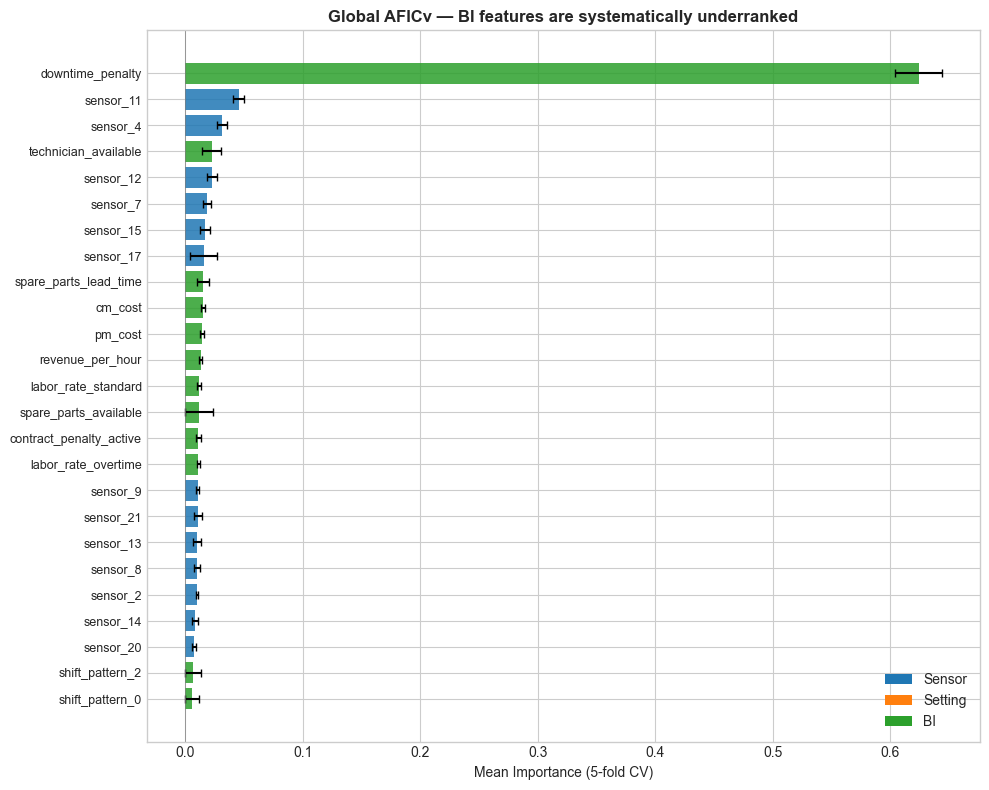

In [4]:
# Visualize the bias: importance bar chart colored by type
imp_global = global_selector.get_importance_table()

def feature_type(name):
    if name.startswith('sensor_'): return 'Sensor'
    elif name.startswith('setting_'): return 'Setting'
    else: return 'BI'

imp_global['type'] = imp_global['feature'].apply(feature_type)
type_colors = {'Sensor': '#1f77b4', 'Setting': '#ff7f0e', 'BI': '#2ca02c'}

top_n = min(25, len(imp_global))
top = imp_global.head(top_n).iloc[::-1]

fig, ax = plt.subplots(figsize=(10, 8))
colors = [type_colors[t] for t in top['type']]
ax.barh(range(top_n), top['mean_importance'], xerr=top['std_importance'],
        color=colors, alpha=0.85, capsize=3)
ax.set_yticks(range(top_n))
ax.set_yticklabels(top['feature'], fontsize=9)
ax.set_xlabel('Mean Importance (5-fold CV)')
ax.set_title('Global AFICv — BI features are systematically underranked', fontweight='bold')
ax.axvline(x=0, color='gray', linewidth=0.5)

legend_elements = [Patch(facecolor=c, label=t) for t, c in type_colors.items()]
ax.legend(handles=legend_elements, loc='lower right')
plt.tight_layout()
plt.show()

---
## 3. Stratified AFICv (recommended)
Separate AFICv on each modality, then combine. Each group is evaluated against its own peers.

In [5]:
strat_selector = AFICvFeatureSelector(
    base_learner='xgboost',
    n_folds=5,
    cumulative_threshold=0.70,
)

strat_selected = strat_selector.select_features_stratified(
    data=train_fused,
    sensor_cols=sensor_cols,
    bi_cols=bi_cols,
    setting_cols=setting_cols,
    target_col='rul',
    group_col='unit',
)


AFICv Feature Selection (Stratified)
  Learner: xgboost, K=5
  Sensor/Setting: 24 candidates, threshold=70%
  BI:             17 candidates, threshold=70%

--- Sensor/Setting Group (24 features) ---
  [Sensor] Fold 1/5: R²=0.8358
  [Sensor] Fold 2/5: R²=0.7660
  [Sensor] Fold 3/5: R²=0.8136
  [Sensor] Fold 4/5: R²=0.7966
  [Sensor] Fold 5/5: R²=0.7785

  Sensor selected: 3/24 (coverage=72.3%)
  → ['sensor_11', 'sensor_4', 'sensor_9']

--- BI Group (17 features) ---
  [BI] Fold 1/5: R²=0.8716
  [BI] Fold 2/5: R²=0.8686
  [BI] Fold 3/5: R²=0.8753
  [BI] Fold 4/5: R²=0.8890
  [BI] Fold 5/5: R²=0.8722

  BI selected: 1/17 (coverage=74.6%)
  → ['downtime_penalty']

  TOTAL: 4 features (3 sensor/setting + 1 BI)


---
## 4. Stratified Importance Plots

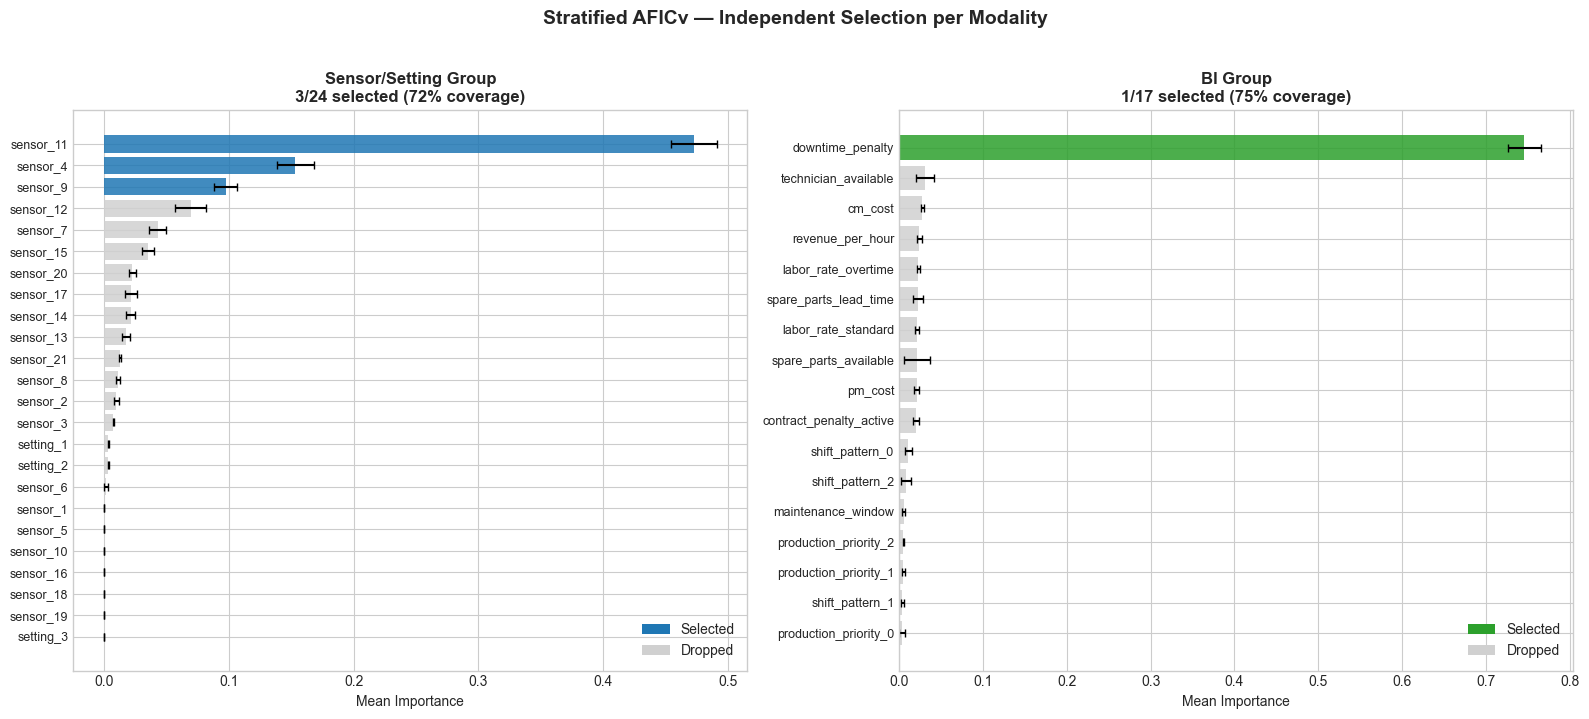

In [6]:
imp_sensor = strat_selector.get_importance_table(group='sensor')
imp_bi = strat_selector.get_importance_table(group='bi')
report = strat_selector.get_report()

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# --- Left: Sensor group ---
n_s = len(imp_sensor)
s_data = imp_sensor.iloc[::-1]
s_colors = ['#1f77b4' if f in report['sensor_features'] else '#d0d0d0' for f in s_data['feature']]
axes[0].barh(range(n_s), s_data['mean_importance'], xerr=s_data['std_importance'],
             color=s_colors, alpha=0.85, capsize=3)
axes[0].set_yticks(range(n_s))
axes[0].set_yticklabels(s_data['feature'], fontsize=9)
axes[0].set_xlabel('Mean Importance')
axes[0].set_title(f"Sensor/Setting Group\n{report['sensor_selected']}/{report['sensor_candidates']} selected "
                  f"({report['sensor_coverage']*100:.0f}% coverage)", fontweight='bold')
axes[0].legend(handles=[
    Patch(facecolor='#1f77b4', label='Selected'),
    Patch(facecolor='#d0d0d0', label='Dropped'),
], loc='lower right')

# --- Right: BI group ---
n_b = len(imp_bi)
b_data = imp_bi.iloc[::-1]
b_colors = ['#2ca02c' if f in report['bi_features'] else '#d0d0d0' for f in b_data['feature']]
axes[1].barh(range(n_b), b_data['mean_importance'], xerr=b_data['std_importance'],
             color=b_colors, alpha=0.85, capsize=3)
axes[1].set_yticks(range(n_b))
axes[1].set_yticklabels(b_data['feature'], fontsize=9)
axes[1].set_xlabel('Mean Importance')
axes[1].set_title(f"BI Group\n{report['bi_selected']}/{report['bi_candidates']} selected "
                  f"({report['bi_coverage']*100:.0f}% coverage)", fontweight='bold')
axes[1].legend(handles=[
    Patch(facecolor='#2ca02c', label='Selected'),
    Patch(facecolor='#d0d0d0', label='Dropped'),
], loc='lower right')

fig.suptitle('Stratified AFICv — Independent Selection per Modality', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

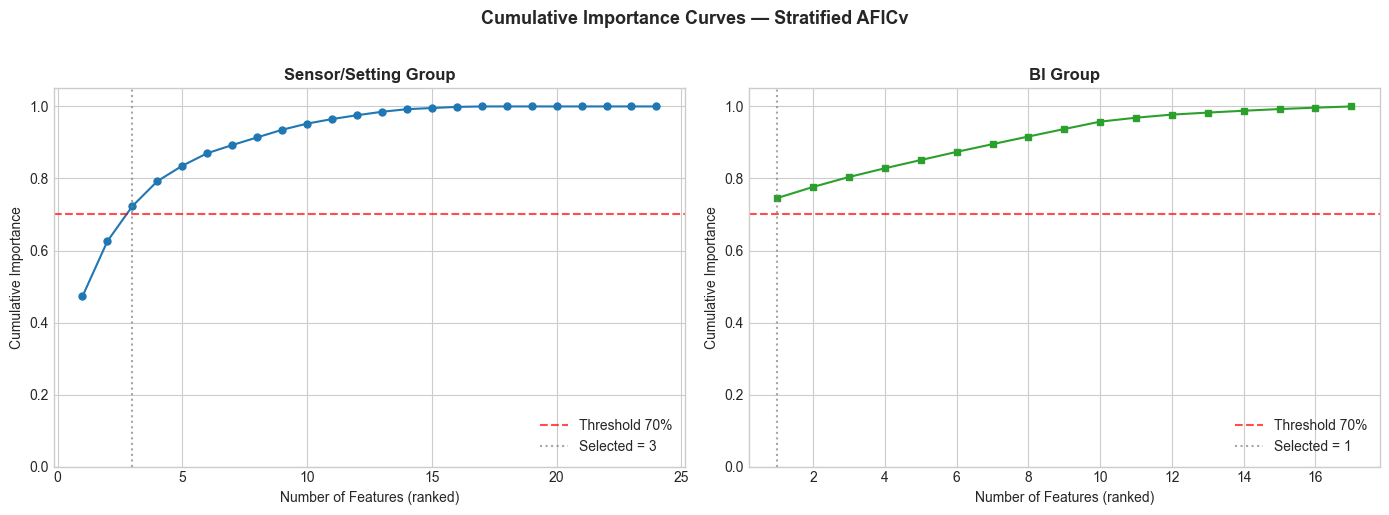

In [7]:
# Cumulative importance curves side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sensor
axes[0].plot(range(1, len(imp_sensor)+1), imp_sensor['cumulative'], 'o-', 
             color='#1f77b4', markersize=5)
axes[0].axhline(y=0.70, color='red', linestyle='--', alpha=0.7, label='Threshold 70%')
axes[0].axvline(x=report['sensor_selected'], color='gray', linestyle=':', alpha=0.7,
                label=f"Selected = {report['sensor_selected']}")
axes[0].set_xlabel('Number of Features (ranked)')
axes[0].set_ylabel('Cumulative Importance')
axes[0].set_title('Sensor/Setting Group', fontweight='bold')
axes[0].legend()
axes[0].set_ylim(0, 1.05)

# BI
axes[1].plot(range(1, len(imp_bi)+1), imp_bi['cumulative'], 's-',
             color='#2ca02c', markersize=5)
axes[1].axhline(y=0.70, color='red', linestyle='--', alpha=0.7, label='Threshold 70%')
axes[1].axvline(x=report['bi_selected'], color='gray', linestyle=':', alpha=0.7,
                label=f"Selected = {report['bi_selected']}")
axes[1].set_xlabel('Number of Features (ranked)')
axes[1].set_ylabel('Cumulative Importance')
axes[1].set_title('BI Group', fontweight='bold')
axes[1].legend()
axes[1].set_ylim(0, 1.05)

plt.suptitle('Cumulative Importance Curves — Stratified AFICv', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## 5. Global vs Stratified Comparison

In [8]:
# Also run correlation-based for 3-way comparison
corr_selector = BIAwareFeatureSelector(variance_threshold=0.01, correlation_threshold=0.95)
corr_selected = corr_selector.select_features(
    data=train_fused, sensor_cols=sensor_cols,
    bi_cols=bi_cols, setting_cols=setting_cols,
    exclude_cols=meta_cols,
)

def count_types(features):
    s = sum(1 for f in features if f.startswith('sensor_') or f.startswith('setting_'))
    return s, len(features) - s

methods = {
    'Correlation-based': corr_selected,
    'AFICv Global': global_selected,
    'AFICv Stratified': strat_selected,
}

print("=== Three-Way Comparison (FD001) ===\n")
print(f"{'Method':<22} {'Total':>6} {'Sensor':>8} {'BI':>6}")
print('-' * 45)
for name, feats in methods.items():
    s, b = count_types(feats)
    print(f"{name:<22} {len(feats):>6} {s:>8} {b:>6}")


=== BI-Aware Feature Selection ===
  Input: 21 sensor + 17 BI + 3 setting = 41 total
  Variance filter (sensor/settings only):
    Removed 9: ['sensor_1', 'sensor_5', 'sensor_9', 'sensor_10', 'sensor_14', 'sensor_16', 'sensor_18', 'sensor_19', 'setting_3']
    Kept 15 sensor/setting features
    BI features: 17 (all exempt, all kept)
  Correlation filter (tau=0.95):
    Removed 0:
  Final: 32 features (15 sensor/setting + 17 BI)
=== Three-Way Comparison (FD001) ===

Method                  Total   Sensor     BI
---------------------------------------------
Correlation-based          32       15     17
AFICv Global                3        2      1
AFICv Stratified            4        3      1


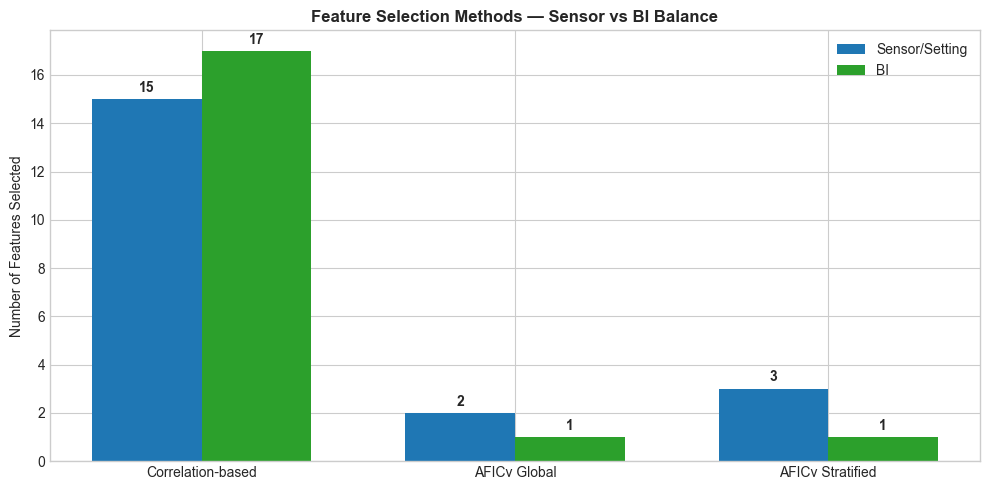

In [9]:
# Visual comparison
fig, ax = plt.subplots(figsize=(10, 5))

method_names = list(methods.keys())
x = np.arange(len(method_names))
width = 0.35

sensor_counts = [count_types(methods[m])[0] for m in method_names]
bi_counts = [count_types(methods[m])[1] for m in method_names]

bars1 = ax.bar(x - width/2, sensor_counts, width, label='Sensor/Setting', color='#1f77b4')
bars2 = ax.bar(x + width/2, bi_counts, width, label='BI', color='#2ca02c')

for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
            str(int(bar.get_height())), ha='center', fontweight='bold')
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
            str(int(bar.get_height())), ha='center', fontweight='bold')

ax.set_xticks(x)
ax.set_xticklabels(method_names)
ax.set_ylabel('Number of Features Selected')
ax.set_title('Feature Selection Methods — Sensor vs BI Balance', fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

In [10]:
# Detailed feature overlap table
all_feats = sorted(set(corr_selected) | set(global_selected) | set(strat_selected))

comparison = pd.DataFrame({
    'feature': all_feats,
    'type': [feature_type(f) for f in all_feats],
    'Correlation': ['✓' if f in corr_selected else '' for f in all_feats],
    'Global': ['✓' if f in global_selected else '' for f in all_feats],
    'Stratified': ['✓' if f in strat_selected else '' for f in all_feats],
})

comparison['consensus'] = comparison[['Correlation', 'Global', 'Stratified']].apply(
    lambda row: sum(1 for v in row if v == '✓'), axis=1)

comparison.sort_values(['type', 'consensus'], ascending=[True, False])

,feature,type,Correlation,Global,Stratified,consensus
2,downtime_penalty,BI,✓,✓,✓,3
0,cm_cost,BI,✓,,,1
1,contract_penalty_active,BI,✓,,,1
3,labor_rate_overtime,BI,✓,,,1
4,labor_rate_standard,BI,✓,,,1
5,maintenance_window,BI,✓,,,1
6,pm_cost,BI,✓,,,1
7,production_priority_0,BI,✓,,,1
8,production_priority_1,BI,✓,,,1
9,production_priority_2,BI,✓,,,1


---
## 6. Sensitivity: Base Learner Stability (Stratified)

In [11]:
learners = ['xgboost', 'random_forest', 'gradient_boosting']
learner_results = {}

for learner in learners:
    sel = AFICvFeatureSelector(
        base_learner=learner, n_folds=5, cumulative_threshold=0.70,
    )
    selected = sel.select_features_stratified(
        data=train_fused, sensor_cols=sensor_cols,
        bi_cols=bi_cols, setting_cols=setting_cols,
        target_col='rul', group_col='unit',
    )
    learner_results[learner] = {
        'selected': set(selected),
        'report': sel.get_report(),
    }

print(f"\n{'='*60}")
print("=== Base Learner Stability (Stratified) ===\n")
print(f"{'Learner':<25} {'Total':>6} {'Sensor':>8} {'BI':>6}")
print('-' * 48)
for l, r in learner_results.items():
    s, b = count_types(r['selected'])
    print(f"{l:<25} {len(r['selected']):>6} {s:>8} {b:>6}")

# Consensus
consensus = learner_results['xgboost']['selected']
for r in learner_results.values():
    consensus = consensus & r['selected']
s_c, b_c = count_types(consensus)
print(f"\nConsensus (all 3):    {len(consensus):>6} ({s_c} sensor + {b_c} BI)")
print(f"  → {sorted(consensus)}")


AFICv Feature Selection (Stratified)
  Learner: xgboost, K=5
  Sensor/Setting: 24 candidates, threshold=70%
  BI:             17 candidates, threshold=70%

--- Sensor/Setting Group (24 features) ---
  [Sensor] Fold 1/5: R²=0.8358
  [Sensor] Fold 2/5: R²=0.7660
  [Sensor] Fold 3/5: R²=0.8136
  [Sensor] Fold 4/5: R²=0.7966
  [Sensor] Fold 5/5: R²=0.7785

  Sensor selected: 3/24 (coverage=72.3%)
  → ['sensor_11', 'sensor_4', 'sensor_9']

--- BI Group (17 features) ---
  [BI] Fold 1/5: R²=0.8716
  [BI] Fold 2/5: R²=0.8686
  [BI] Fold 3/5: R²=0.8753
  [BI] Fold 4/5: R²=0.8890
  [BI] Fold 5/5: R²=0.8722

  BI selected: 1/17 (coverage=74.6%)
  → ['downtime_penalty']

  TOTAL: 4 features (3 sensor/setting + 1 BI)

AFICv Feature Selection (Stratified)
  Learner: random_forest, K=5
  Sensor/Setting: 24 candidates, threshold=70%
  BI:             17 candidates, threshold=70%

--- Sensor/Setting Group (24 features) ---
  [Sensor] Fold 1/5: R²=0.8327
  [Sensor] Fold 2/5: R²=0.7702
  [Sensor] Fold 

---
## 7. Sensitivity: Threshold Impact (Stratified)


AFICv Feature Selection (Stratified)
  Learner: xgboost, K=5
  Sensor/Setting: 24 candidates, threshold=50%
  BI:             17 candidates, threshold=50%

--- Sensor/Setting Group (24 features) ---
  [Sensor] Fold 1/5: R²=0.8358
  [Sensor] Fold 2/5: R²=0.7660
  [Sensor] Fold 3/5: R²=0.8136
  [Sensor] Fold 4/5: R²=0.7966
  [Sensor] Fold 5/5: R²=0.7785

  Sensor selected: 2/24 (coverage=62.6%)
  → ['sensor_11', 'sensor_4']

--- BI Group (17 features) ---
  [BI] Fold 1/5: R²=0.8716
  [BI] Fold 2/5: R²=0.8686
  [BI] Fold 3/5: R²=0.8753
  [BI] Fold 4/5: R²=0.8890
  [BI] Fold 5/5: R²=0.8722

  BI selected: 1/17 (coverage=74.6%)
  → ['downtime_penalty']

  TOTAL: 3 features (2 sensor/setting + 1 BI)

AFICv Feature Selection (Stratified)
  Learner: xgboost, K=5
  Sensor/Setting: 24 candidates, threshold=60%
  BI:             17 candidates, threshold=60%

--- Sensor/Setting Group (24 features) ---
  [Sensor] Fold 1/5: R²=0.8358
  [Sensor] Fold 2/5: R²=0.7660
  [Sensor] Fold 3/5: R²=0.8136
  [

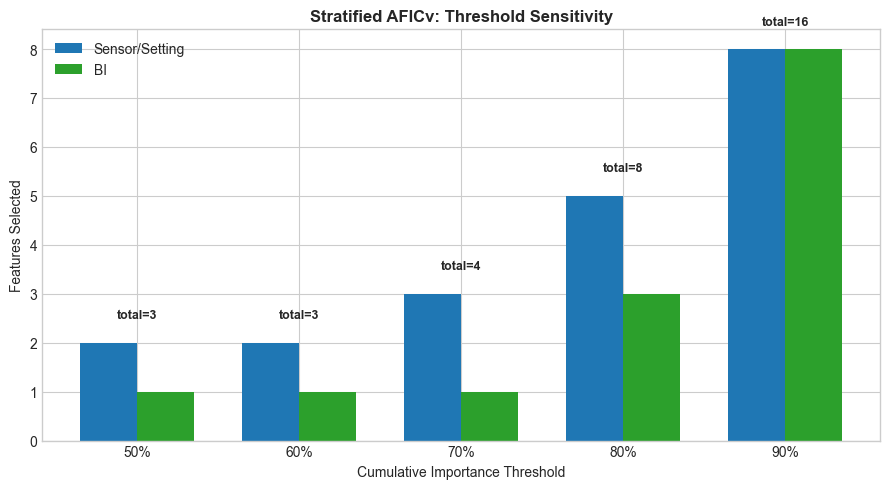

In [12]:
thresholds = [0.50, 0.60, 0.70, 0.80, 0.90]
thresh_results = []

for t in thresholds:
    sel = AFICvFeatureSelector(
        base_learner='xgboost', n_folds=5, cumulative_threshold=t,
    )
    selected = sel.select_features_stratified(
        data=train_fused, sensor_cols=sensor_cols,
        bi_cols=bi_cols, setting_cols=setting_cols,
        target_col='rul', group_col='unit',
    )
    r = sel.get_report()
    thresh_results.append({
        'threshold': f"{t*100:.0f}%",
        'sensor_selected': r['sensor_selected'],
        'bi_selected': r['bi_selected'],
        'total': r['total_selected'],
    })

thresh_df = pd.DataFrame(thresh_results)
print("\n=== Threshold Sensitivity (Stratified) ===")
print(thresh_df.to_string(index=False))

fig, ax = plt.subplots(figsize=(9, 5))
x = np.arange(len(thresholds))
width = 0.35
ax.bar(x - width/2, thresh_df['sensor_selected'], width, label='Sensor/Setting', color='#1f77b4')
ax.bar(x + width/2, thresh_df['bi_selected'], width, label='BI', color='#2ca02c')
ax.set_xticks(x)
ax.set_xticklabels(thresh_df['threshold'])
ax.set_xlabel('Cumulative Importance Threshold')
ax.set_ylabel('Features Selected')
ax.set_title('Stratified AFICv: Threshold Sensitivity', fontweight='bold')
ax.legend()

for i, row in thresh_df.iterrows():
    ax.text(i, max(row['sensor_selected'], row['bi_selected']) + 0.5,
            f"total={row['total']}", ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

---
## 8. Which BI Features Matter Most?
Key question for the thesis: do the degradation-correlated BI variables rank higher?

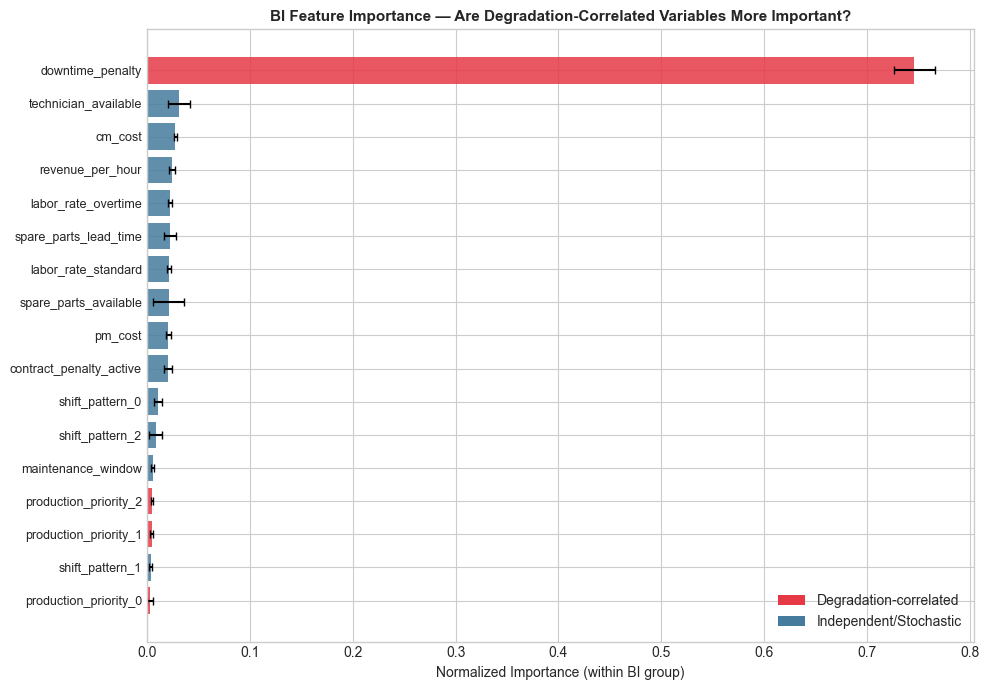


BI Importance Ranking:
                feature  normalized  cumulative              corr_type
       downtime_penalty    0.745776    0.745776 Degradation-correlated
   technician_available    0.030849    0.776625 Independent/Stochastic
                cm_cost    0.027557    0.804181 Independent/Stochastic
       revenue_per_hour    0.024215    0.828397 Independent/Stochastic
    labor_rate_overtime    0.022825    0.851221 Independent/Stochastic
  spare_parts_lead_time    0.022659    0.873881 Independent/Stochastic
    labor_rate_standard    0.021432    0.895312 Independent/Stochastic
  spare_parts_available    0.021225    0.916537 Independent/Stochastic
                pm_cost    0.020775    0.937312 Independent/Stochastic
contract_penalty_active    0.020519    0.957830 Independent/Stochastic
        shift_pattern_0    0.010931    0.968761 Independent/Stochastic
        shift_pattern_2    0.008618    0.977379 Independent/Stochastic
     maintenance_window    0.005586    0.982965 Indep

In [13]:
imp_bi = strat_selector.get_importance_table(group='bi')

# Mark degradation-correlated variables
degradation_correlated = ['downtime_penalty']
degradation_correlated += [c for c in imp_bi['feature'] if c.startswith('production_priority_')]

imp_bi['corr_type'] = imp_bi['feature'].apply(
    lambda f: 'Degradation-correlated' if f in degradation_correlated else 'Independent/Stochastic'
)

fig, ax = plt.subplots(figsize=(10, 7))
data_plot = imp_bi.iloc[::-1]
colors = ['#e63946' if t == 'Degradation-correlated' else '#457b9d' 
          for t in data_plot['corr_type']]

ax.barh(range(len(data_plot)), data_plot['normalized'], 
        xerr=data_plot['std_importance'] / data_plot['mean_importance'].sum(),
        color=colors, alpha=0.85, capsize=3)
ax.set_yticks(range(len(data_plot)))
ax.set_yticklabels(data_plot['feature'], fontsize=9)
ax.set_xlabel('Normalized Importance (within BI group)')
ax.set_title('BI Feature Importance — Are Degradation-Correlated Variables More Important?',
             fontweight='bold', fontsize=11)
ax.legend(handles=[
    Patch(facecolor='#e63946', label='Degradation-correlated'),
    Patch(facecolor='#457b9d', label='Independent/Stochastic'),
], loc='lower right')

plt.tight_layout()
plt.show()

print("\nBI Importance Ranking:")
print(imp_bi[['feature', 'normalized', 'cumulative', 'corr_type']].to_string(index=False))

---
## 9. Summary

| Aspect | Correlation-Based | AFICv Global | AFICv Stratified |
|:---|:---|:---|:---|
| **Criterion** | Variance + pairwise correlation | Tree-based importance (all features) | Tree-based importance (per group) |
| **BI handling** | Exempt from variance filter | Competes with sensors (unfair) | Evaluated within own modality |
| **Multi-rate bias** | Not applicable | Yes — sensors dominate | No — groups are independent |
| **Advantages** | Fast, no training | Data-driven | Data-driven + fair multi-modal |
| **Methodology ref.** | Eq. 10, 12 | Eq. 13 | Eq. 13 (stratified extension) |

### Key findings:
- **Global AFICv** systematically underranks BI features due to their lower update frequency (step-function vs continuous signals)
- **Stratified AFICv** ensures both sensor and BI modalities contribute their most informative features
- Degradation-correlated BI variables (`production_priority`, `downtime_penalty`) should rank higher within the BI group
- The 70% threshold provides a principled feature count; adjust per-group thresholds if needed